In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 

import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [25]:
#get information from the shp file, without creating the output tif files
#CAREFULL! THE INDEX HERE IS DIFFERENT FROM THE ONES ON THE OTHER FILES, 
#SINCE THE SHP FILE WE ARE USING IS NOT THE SAME: 2 GLACEIRS ARE HERE MISSING

#path_to_tif = '/Users/francesco/Desktop/Data/CALVIN/'
path_to_tif = '/Users/francesco/Desktop/Thesis/Data/oceanice/'
shapefile_path = '/Users/francesco/Desktop/Thesis/Data/iceshelf_flux_greene.gpkg'

ids = []
id_measures = []
Names = []
Names_1 = []
ice_calving_time_series_shp = []
ice_calving_time_series_shp_sd = []
boundaries = []

years = np.arange(2000,2022,1)

shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])


for feature in shapefile:

    id = feature['id']
    id_measure = feature['properties']['id_measures']
    name=feature['properties']['measures_name']
    name_1 = feature['properties']['ice_shelf_name']
    geometry=feature['geometry']
    if geometry is None:
        print('No geometry for this feature' + str(id_measure))
        continue 
    bounds=shape(geometry).bounds
    xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]
    bounds_temp = [xmin,ymin,xmax,ymax]
 

    #print(id,name,geometry)

    ids.append(id)
    Names.append(name)
    ice_calvinng_temp_glacier = []
    ice_calvinng_temp_glacier_sd = []
    boundaries.append(bounds_temp)
    Names_1.append(name_1)
    id_measures.append(id_measure)

    for year in years:

        ice_calving_temp_year = feature['properties']['mass_change_'+str(year)]
        ice_calving_temp_year_sd = feature['properties']['mass_change_'+str(year)+'_sd']

        if ice_calving_temp_year>0:
            ice_calvinng_temp_glacier.append(ice_calving_temp_year)
            ice_calvinng_temp_glacier_sd.append(ice_calving_temp_year_sd)
        else:
            ice_calvinng_temp_glacier.append(0)
            ice_calvinng_temp_glacier_sd.append(0)

    ice_calving_time_series_shp.append(ice_calvinng_temp_glacier)
    ice_calving_time_series_shp_sd.append(ice_calvinng_temp_glacier_sd)

{'id_measures': 'int', 'index': 'int', 'ice_shelf_name': 'str:50', 'measures_name': 'str:50', 'latitude': 'float', 'longitude': 'float', 'thickness_trend_97_17_obs': 'float', 'thickness_trend_97_17_sd': 'float', 'smb_mean_97_17_obs': 'float', 'smb_mean_97_17_sd': 'float', 'ss_gl_flux_obs': 'float', 'ss_gl_flux_sd': 'float', 'ss_calving_flux_obs': 'float', 'ss_calving_flux_sd': 'float', 'model_gl_flux_control': 'float', 'instant_collapse_flux': 'float', 'mass_change_97': 'float', 'mass_change_97_sd': 'float', 'mass_change_2000': 'float', 'mass_change_2000_sd': 'float', 'mass_change_2000_75': 'float', 'mass_change_2000_75_sd': 'float', 'mass_change_2001': 'float', 'mass_change_2001_sd': 'float', 'mass_change_2002': 'float', 'mass_change_2002_sd': 'float', 'mass_change_2003': 'float', 'mass_change_2003_sd': 'float', 'mass_change_2004': 'float', 'mass_change_2004_sd': 'float', 'mass_change_2005': 'float', 'mass_change_2005_sd': 'float', 'mass_change_2006': 'float', 'mass_change_2006_sd': '

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.

ERROR 10: Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.



In [12]:
np.shape(ice_calving_time_series_shp[0])

(22,)

In [26]:
#creating a dataset for
df_ice_calving = pd.DataFrame(columns = ['Name'] + years.tolist(), index=ids)
df_ice_calving['Name'] = Names

for i in range(len(ids)):
    df_ice_calving.loc[ids[i],years] = ice_calving_time_series_shp[i]

df_ice_calving['id_measures'] = id_measures
df_ice_calving.set_index('id_measures', inplace=True)


#Save it as a csv file
#df_ice_calving.to_csv(os.getcwd() + '/df_ice_calving_shp_negative_and_positive.csv')

In [27]:
unique_vals, counts = np.unique(id_measures, return_counts=True)
if np.any(counts > 1):
    print("There are repeated values in the array.")
else:
    print("All values in the array are unique.")

All values in the array are unique.


In [28]:
print(np.shape(id_measures))

(179,)


In [30]:

#Here I create the tif files for each shelves for each year (11 mins)


#path_to_tif = '/Users/francesco/Desktop/Thesis/Data/CALVING/' old one
path_to_tif = '/Users/francesco/Desktop/Thesis/Data/oceanice/'
shapefile_path = '/Users/francesco/Desktop/Thesis/Data/iceshelf_flux_greene.gpkg'
#shapefile_path = '/Users/francesco/Desktop/Thesis/Data/ice_shelf.shp'


''' 
for year in years:

    #identifying the geotif file in GEOTIFFs directory
    file_tif = path_to_tif + 'FluxGreen' + str(year) + '.tif'
    print(year)

    shapefile=fiona.open(shapefile_path)

    for feature in shapefile:


        id = feature['id']
        geometry=feature['geometry']
        id_measure = feature['properties']['id_measures']

        if geometry is None:
            continue  # skip this feature if geometry is missing
        bounds=shape(geometry).bounds

        xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]

        output_file = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/' + str(id_measure) + '_' + str(year) + '.tif'

        # the next command line is saving all the geotiff files in the directory.        
        os.system('gdalwarp -t_srs EPSG:3031 -te '+str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+file_tif+' '+ output_file)

'''

" \nfor year in years:\n\n    #identifying the geotif file in GEOTIFFs directory\n    file_tif = path_to_tif + 'FluxGreen' + str(year) + '.tif'\n    print(year)\n\n    shapefile=fiona.open(shapefile_path)\n\n    for feature in shapefile:\n\n\n        id = feature['id']\n        geometry=feature['geometry']\n        id_measure = feature['properties']['id_measures']\n\n        if geometry is None:\n            continue  # skip this feature if geometry is missing\n        bounds=shape(geometry).bounds\n\n        xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]\n\n        output_file = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/' + str(id_measure) + '_' + str(year) + '.tif'\n\n        # the next command line is saving all the geotiff files in the directory.        \n        os.system('gdalwarp -t_srs EPSG:3031 -te '+str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+file_tif+' '+ output_file)\n\n"

In [40]:
#Here I create the dataset glacier_ice_calving with the integrated ice shelving calving fluxes (42 secs)



glacier_ice_calving_tif = pd.DataFrame(index = id_measures, columns = years)

file_path_to_gen_tif = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/'
''' 
for id_measure in id_measures:

    print('Glacier number: ', id_measure)
    
    for year in years:

        file_tif_to_data_set = file_path_to_gen_tif + f"{id_measure}_{year}.tif"

        with rasterio.open(file_tif_to_data_set) as src:
            ice_calving_flux = src.read(1)
            glacier_ice_calving_tif.loc[id_measure,year] = np.nansum(ice_calving_flux)

# Saving the dataset in the current directory
glacier_ice_calving_tif.to_csv(os.getcwd() + '/Glacier_ice_calving_with_ice_shelves_flux_greene.csv')

'''


' \nfor id_measure in id_measures:\n\n    print(\'Glacier number: \', id_measure)\n    \n    for year in years:\n\n        file_tif_to_data_set = file_path_to_gen_tif + f"{id_measure}_{year}.tif"\n\n        with rasterio.open(file_tif_to_data_set) as src:\n            ice_calving_flux = src.read(1)\n            glacier_ice_calving_tif.loc[id_measure,year] = np.nansum(ice_calving_flux)\n\n# Saving the dataset in the current directory\nglacier_ice_calving_tif.to_csv(os.getcwd() + \'/Glacier_ice_calving_with_ice_shelves_flux_greene.csv\')\n\n'

In [32]:
glacier_ice_calving_tif = pd.read_csv(os.getcwd() + '/Glacier_ice_calving_withice_shelves_flux_greene.csv', index_col = 0)


In [33]:
glacier_ice_calving_tif.loc[8]

2000    69.910000
2001     0.057355
2002    27.070000
2003    18.740000
2004     0.000000
2005     0.249600
2006    15.950000
2007    33.807435
2008    49.740000
2009     1.320000
2010     3.528159
2011    31.658378
2012    35.441646
2013    44.441425
2014     5.701224
2015    32.610000
2016    28.831603
2017    33.500000
2018     0.588419
2019     7.826736
2020     0.758360
2021    16.232508
Name: 8, dtype: float64

In [34]:
#Are they all always increasing? Yes

np.all(np.diff(glacier_ice_calving_tif) >= 0, axis=1)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [35]:
glacier_ice_calving_yearly_tif = glacier_ice_calving_tif
glacier_ice_calving_yearly_tif.shape

(179, 22)

In [36]:
np.shape(ice_calving_time_series_shp)
#np.shape(id_measures)

(179, 22)

In [37]:
indice = 1
glacier_ice_calving_yearly_tif.iloc[indice,:]

2000    0.00
2001    0.44
2002    0.00
2003    0.07
2004    0.03
2005    0.00
2006    0.18
2007    0.24
2008    0.24
2009    0.00
2010    0.00
2011    0.00
2012    0.08
2013    0.00
2014    0.00
2015    0.00
2016    0.00
2017    0.10
2018    0.13
2019    0.12
2020    0.06
2021    0.00
Name: 111, dtype: float64

In [38]:
#Graph for each glacier



with PdfPages('Glaciers.pdf') as pdf:

    for indice in range(0,len(id_measures)):

        #print(indice)
        x = np.array(ice_calving_time_series_shp[indice])
        x_sd = np.array(ice_calving_time_series_shp_sd[indice])

        fig =plt.figure()

        plt.plot(years, glacier_ice_calving_yearly_tif.iloc[indice,:], label = 'Calving flux from tif', color = 'red')
        plt.plot(years, ice_calving_time_series_shp[indice], label = 'Calving flux from shp', color = 'blue')
        plt.fill_between(years, x-x_sd, x+x_sd, alpha = 0.5, label = 'Standard deviation', color = 'green')
        plt.title('Glacier ' +str(Names[indice]) + ', id: ' + str(id_measures[indice]))

        plt.xlabel('Years')
        plt.ylabel('Integrated ice calving flux [???]')

        plt.legend()
        pdf.savefig(fig)

        plt.close()



''' 

'''

' \n\n'

In [15]:
interesting_glaciers = ['Pine_Island', 'Thwaites', 'Crosson', 'Dotson', 'Getz_2', 'Venable', 'Getz', 'Getz_1' ]
interesting_indices = np.where(np.isin(Names, interesting_glaciers))[0]
interesting_names = np.array(Names)[interesting_indices]

interesting_glaciers_time_series_shp = np.array(ice_calving_time_series_shp)[interesting_indices]
interesting_glaciers_time_series_shp_sd = np.array(ice_calving_time_series_shp_sd)[interesting_indices]

interesting_glacier_time_series_tif = glacier_ice_calving_yearly_tif.iloc[interesting_indices,:]


In [16]:
print(id_measures)

[110, 111, 105, 106, 107, 108, 109, 148, 174, 115, 144, 133, 94, 124, 80, 46, 138, 118, 119, 49, 176, 36, 78, 128, 76, 139, 18, 177, 113, 99, 90, 54, 57, 23, 1, 145, 32, 114, 58, 143, 73, 17, 39, 173, 126, 130, 155, 35, 121, 147, 81, 21, 153, 172, 28, 160, 140, 170, 77, 45, 60, 61, 59, 29, 69, 165, 75, 168, 178, 101, 156, 166, 146, 19, 22, 62, 167, 135, 4, 125, 137, 63, 154, 51, 8, 6, 5, 161, 7, 33, 112, 120, 31, 27, 132, 134, 127, 83, 149, 88, 26, 142, 48, 91, 96, 157, 85, 117, 13, 64, 162, 122, 87, 72, 129, 141, 169, 2, 55, 14, 95, 158, 104, 38, 136, 12, 86, 67, 37, 34, 171, 71, 70, 20, 180, 181, 150, 100, 10, 11, 89, 30, 103, 52, 65, 131, 163, 66, 9, 175, 56, 79, 98, 24, 84, 25, 116, 53, 47, 123, 159, 97, 164, 3, 92, 102, 152, 50, 151, 16, 68, 42, 40, 44, 43, 41, 82, 93, 15]


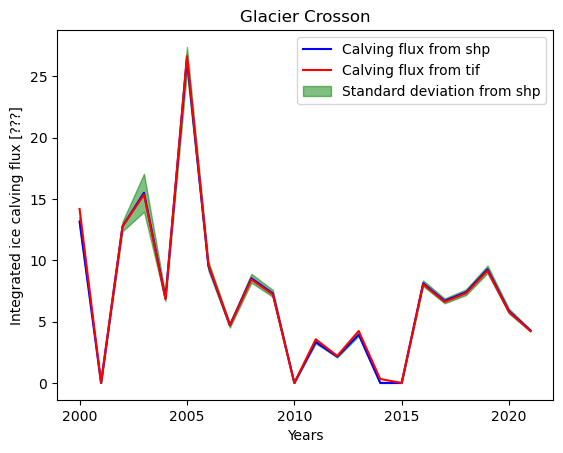

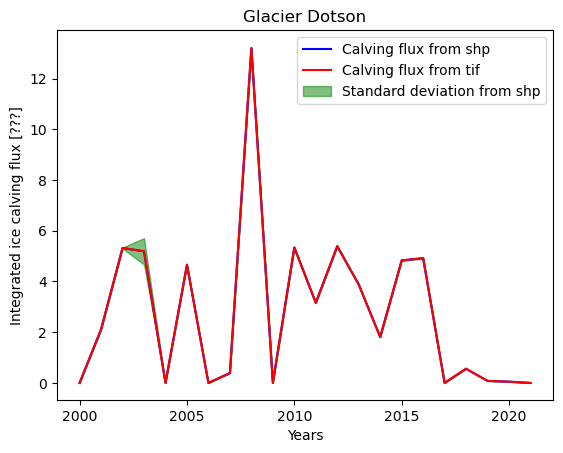

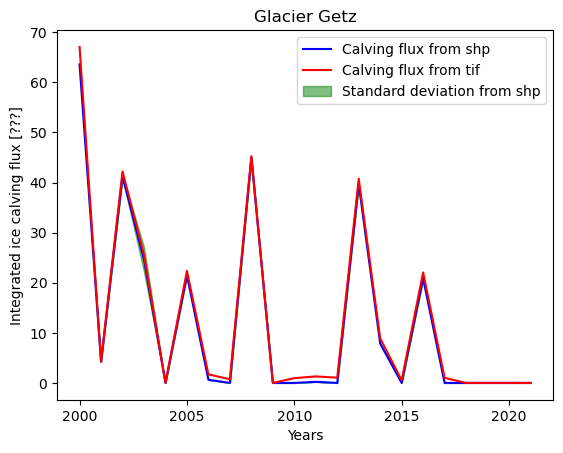

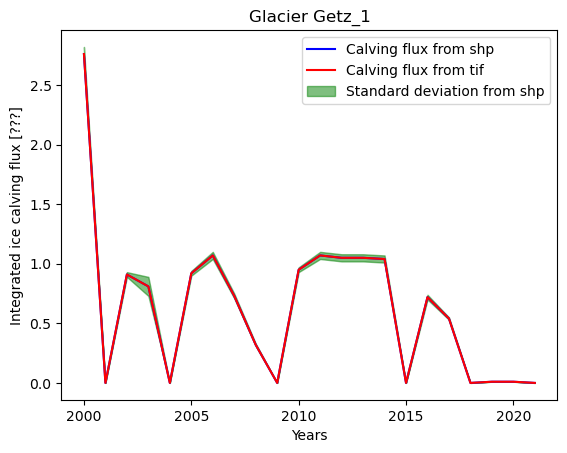

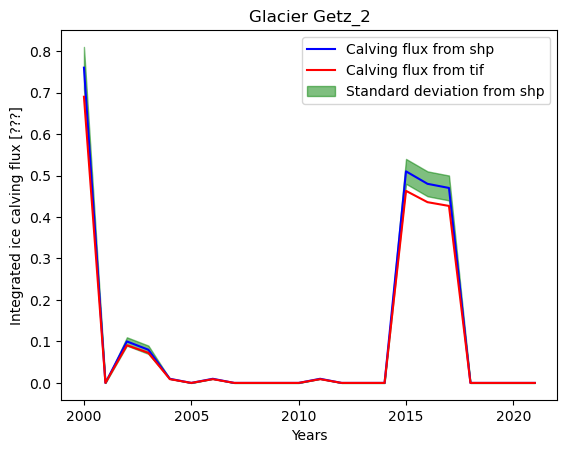

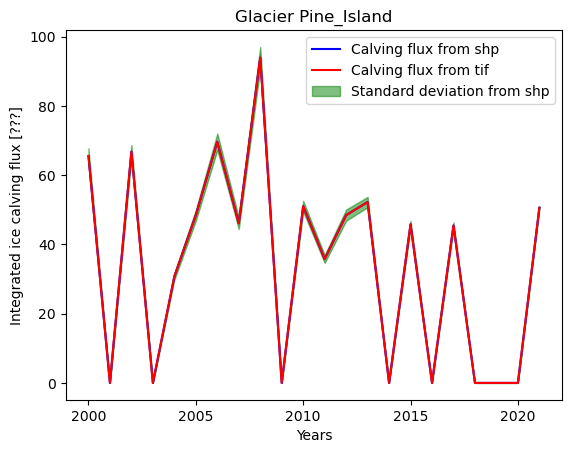

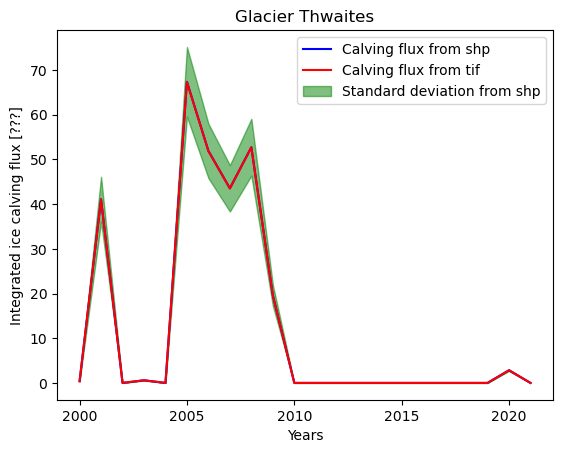

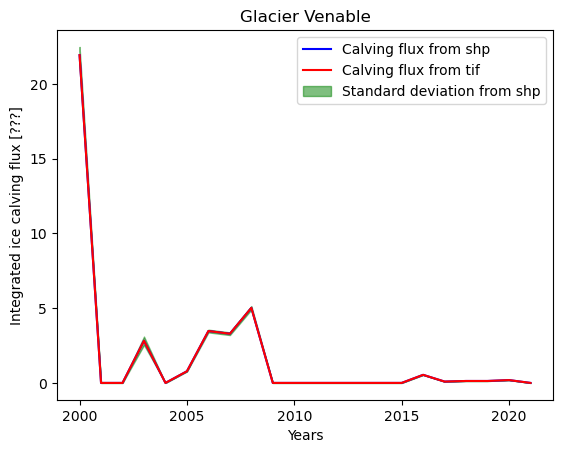

In [17]:
with PdfPages('Interesting_Glaciers.pdf') as pdf:
    for indice in range(0,len(interesting_glaciers)):


        x = np.array(interesting_glaciers_time_series_shp[indice])
        x_sd = np.array(interesting_glaciers_time_series_shp_sd[indice])

        fig =plt.figure()


        plt.plot(years, interesting_glaciers_time_series_shp[indice], label = 'Calving flux from shp', color = 'blue')
        plt.plot(years, interesting_glacier_time_series_tif.iloc[indice], label = 'Calving flux from tif', color = 'red')
        plt.fill_between(years, x-x_sd, x+x_sd, alpha = 0.5, label = 'Standard deviation from shp', color = 'green')
        plt.title('Glacier ' +str(interesting_names[indice]))

        plt.xlabel('Years')
        plt.ylabel('Integrated ice calving flux [???]')

        plt.legend()
        pdf.savefig(fig)
 

In [18]:
interesting_glaciers_time_series_shp[0]

array([13.16,  0.  , 12.76, 15.51,  6.91, 26.4 ,  9.53,  4.7 ,  8.54,
        7.3 ,  0.  ,  3.33,  2.14,  3.94,  0.  ,  0.  ,  8.13,  6.69,
        7.4 ,  9.26,  5.85,  4.28])

In [19]:
id_measures_sort = np.argsort(id_measures)
id_measures_sort

array([ 34, 117, 163,  78,  86,  85,  88,  84, 148, 138, 139, 125, 108,
       119, 178, 169,  41,  26,  73, 133,  51,  74,  33, 153, 155, 100,
        93,  54,  63, 141,  92,  36,  89, 129,  47,  21, 128, 123,  42,
       172, 175, 171, 174, 173,  59,  15, 158, 102,  19, 167,  83, 143,
       157,  31, 118, 150,  32,  38,  62,  60,  61,  75,  81, 109, 144,
       147, 127, 170,  64, 132, 131, 113,  40,  66,  24,  58,  22, 151,
        14,  50, 176,  97, 154, 106, 126, 112,  99, 140,  30, 103, 164,
       177,  12, 120, 104, 161, 152,  29, 137,  69, 165, 142, 122,   2,
         3,   4,   5,   6,   0,   1,  90,  28,  37,   9, 156, 107,  17,
        18,  91,  48, 111, 159,  13,  79,  44,  96,  23, 114,  45, 145,
        94,  11,  95,  77, 124,  80,  16,  25,  56, 115, 101,  39,  10,
        35,  72,  49,   7,  98, 136, 168, 166,  52,  82,  46,  70, 105,
       121, 160,  55,  87, 110, 146, 162,  65,  71,  76,  67, 116,  57,
       130,  53,  43,   8, 149,  20,  27,  68, 134, 135])